In [5]:
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [10]:
url = "https://www.google.com/flights/explore/#explore;f=LHR,LGW,STN,LTN,LCY,SEN,QQS;t=SOF;li=3;lx=7"
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.98 Safari/537.36 OPR/44.0.2510.857")
driver = webdriver.PhantomJS(desired_capabilities=dcap, service_args=['--ignore-ssl-errors=true'])
driver.implicitly_wait(20)
driver.get(url)

In [11]:
driver.save_screenshot(r'image.png')

True

In [12]:
s = BeautifulSoup(driver.page_source, "lxml")
best_price_tags = s.findAll('div', 'LJTSM3-w-e')

best_prices = []
for tag in best_price_tags:
    best_prices.append(float(tag.text.replace('$', '').replace(',', '')))

print best_prices

best_heights_tag = s.findAll('div', 'LJTSM3-w-f')
best_heights = []
for tag in best_heights_tag:
    best_heights.append(float(tag['style'].split('height: ')[1].replace('px;', '')))

print best_heights

[51.0]
[23.954189645970466]


In [13]:
best_price = best_prices[0]
best_height = best_heights[0]
price_per_pixel = best_price / best_height

In [14]:
all_fligths = s.findAll('div', 'LJTSM3-w-x')
fares = []
for flight in all_fligths:
    height = float(flight['style'].split('height: ')[1].replace('px;', ''))
    price = height * price_per_pixel
    fares.append(price)

In [15]:
fares_table = pd.DataFrame(fares, columns=['price'])
fares_table

,price
0,189.706751
1,188.391852
2,162.224365
3,115.118874
4,100.725251
5,90.256249
6,79.787247
7,74.557764
8,74.557764
9,82.407006


In [16]:
fares_table.describe()

,price
count,60.000000
mean,98.709408
std,43.737019
min,51.000000
25%,72.761071
50%,82.407006
75%,115.118874
max,225.680772


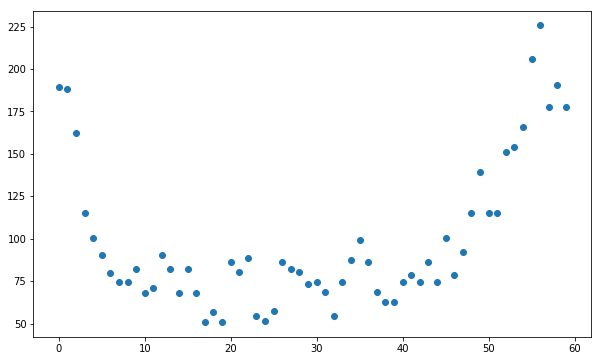

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(np.arange(len(fares_table['price'])), fares_table['price'])

/Users/hakanmehmed/Desktop/mlprojects/airfarescraping/env/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


                min         max  count
cluster                               
0        188.391852  189.706751      2
1        162.224365  162.224365      1
2         51.000000  115.118874     48
3        139.329069  225.680772      9


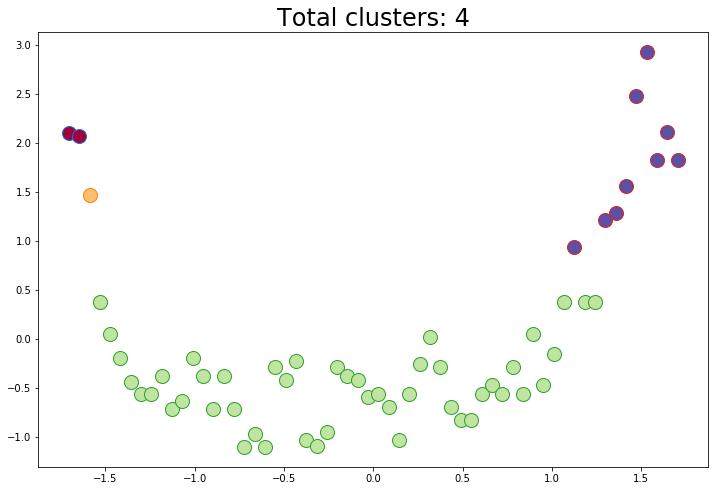

In [18]:
px = [x for x in fares_table['price']]
def test_clusters(data, eps, min_samples):
    ff = pd.DataFrame(px, columns=['fare']).reset_index()
    #take each point, subtract the mean and divide by the standard deviation
    X = StandardScaler().fit_transform(ff)
    #epsilon - min distance between two points
    #min samples - min number of samples to form a cluster
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

    labels = db.labels_
    clusters = len(set(labels))
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    plt.subplots(figsize=(12,8))
    for k,c in zip(unique_labels, colors):
        # returns boolean array
        mask_class = (labels == k)
        xy = X[mask_class]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c, markersize=14)
        plt.title("Total clusters: {}".format(clusters), fontsize=24)
        
    pf = pd.concat([ff, pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
    aggregate = pf.groupby('cluster')['fare'].agg(['min', 'max', 'count'])
    print aggregate
    

test_clusters(px, 0.5, 1)